In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, transforms
import os
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
SAVE_PATH = './data/iaaa/processed/'

In [2]:
MAIN_PATH = './data/iaaa/iaaa_processed/T1/'

In [3]:
def resize_tensor(tensor, target_size=(3, 256, 256)):
    target_depth, target_height, target_width = target_size
    
    resized_tensor = F.interpolate(tensor.unsqueeze(0), size=(target_height, target_width), mode='bilinear', align_corners=False).squeeze(0)
    
    current_depth = resized_tensor.size(0)
    if current_depth < target_depth:
        padding = (0, 0, 0, 0, 0, target_depth - current_depth)
        resized_tensor = F.pad(resized_tensor, padding, mode='constant', value=0)
    elif current_depth > target_depth:
        resized_tensor = resized_tensor[:target_depth, :, :]
    
    return resized_tensor

In [ ]:
npz_files = [f for f in os.listdir(MAIN_PATH) if f.endswith('.npz')][:100]

for npz_file in npz_files:

    npz_file_path = os.path.join(MAIN_PATH, npz_file)
    data = np.load(npz_file_path)
    images = data['x']
    # print(images.shape)
    label = data['y']

    images = images.astype(np.uint8)
    images = torch.tensor(images, dtype=torch.float32)
    # print(images.shape)


    resized_tensor = resize_tensor(images)
    print(resized_tensor.shape)

(18, 256, 256)


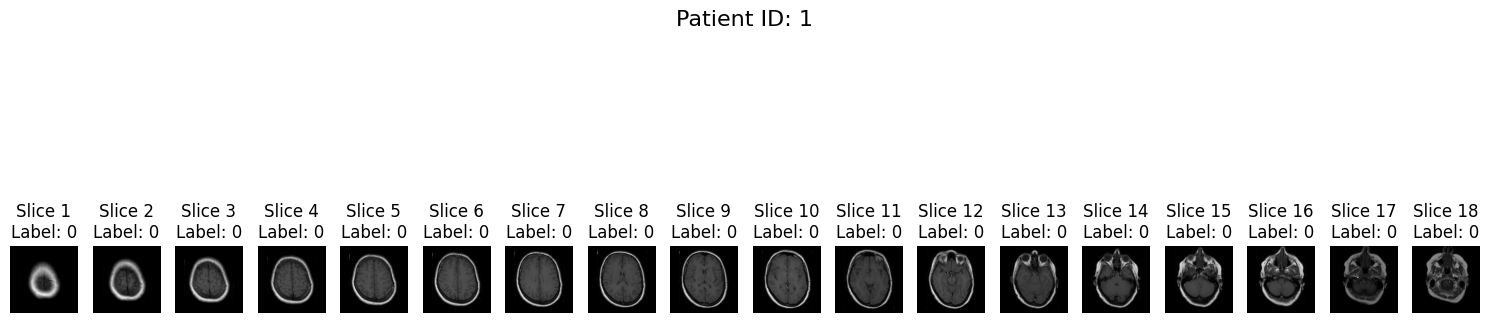

In [23]:
def plot_slices(npz_folder_path):

    for npz_file in os.listdir(npz_folder_path)[5:6]:
        if npz_file.endswith('.npz'):
            npz_file_path = os.path.join(npz_folder_path, npz_file)
            data = np.load(npz_file_path)
            dicom_images = data['x']
            print(dicom_images.shape)
            label = data['y']

            fig, axes = plt.subplots(nrows=1, ncols=len(dicom_images), figsize=(15, 5))
            fig.suptitle(f'Patient ID: {npz_file.split(".")[0]}', fontsize=16)

            for i, dicom_image in enumerate(dicom_images):
                if len(dicom_images) == 1:
                    ax = axes
                else:
                    ax = axes[i]

                ax.imshow(dicom_image, cmap='gray')
                ax.set_title(f'Slice {i+1}\nLabel: {label}')
                ax.axis('off')

            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()

plot_slices(MAIN_PATH)

In [11]:
class IAAADataset(Dataset):
    def __init__(self, main_path, transform=None, train=True, train_size=750):
        self.main_path = main_path
        self.transform = transform
        self.train = train
        self.train_size = train_size

        if self.train:
            self.npz_files = [f for f in os.listdir(main_path) if f.endswith('.npz')][:self.train_size]
        if not self.train:
            self.npz_files = [f for f in os.listdir(main_path) if f.endswith('.npz')][self.train_size:]


    def __len__(self):
        return len(self.npz_files)

    def __getitem__(self, idx):
        
        npz_file_path = os.path.join(self.main_path, self.npz_files[idx])
        data = np.load(npz_file_path)
        images = data['x']
        label = data['y']

        images = images.astype(np.uint8)
        print(images.shape)
        images = [self.transform(image) for image in images]
        images = torch.stack(images, dim=0)
        images = torch.tensor(images, dtype=torch.float32)[5:10, : , :]
        images = resize_tensor(images)
        # images = torch.stack(images, dim=0)

        # print(images.shape)
            
        return images, label

In [ ]:
class ToTensor3D:
    def __call__(self, img):
        img = torch.tensor(img, dtype=torch.float32)
        if img.ndim == 3:  # If (depth, height, width)
            img = img.unsqueeze(0)  # Add channel dimension
        return img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.ToPILImage(),
    # transforms.Grayscale(),
    transforms.ToTensor(),
    # ToTensor3D(),
])

MAIN_PATH = '../data/iaaa/iaaa_processed/T1/'
train_dataset = IAAADataset(main_path=MAIN_PATH, transform=transform)
val_dataset = IAAADataset(main_path=MAIN_PATH, transform=transform, train=False)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
}

for images, label in train_dataloader:
    print(images.shape)
    break

In [19]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [62]:
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(18, 64, kernel_size=3, padding=1),  # Adjusted for 20 channels
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [23]:
model = models.vgg19(pretrained=False)
# model = models.resnet18(pretrained=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
train Loss: 32.9424 Acc: 0.8093
val Loss: 0.3681 Acc: 0.8844
Epoch 2/5
----------
train Loss: 0.4115 Acc: 0.8773
val Loss: 0.3684 Acc: 0.8844
Epoch 3/5
----------
train Loss: 0.3894 Acc: 0.8773
val Loss: 0.3777 Acc: 0.8844
Epoch 4/5
----------
train Loss: 0.3891 Acc: 0.8773
val Loss: 0.3644 Acc: 0.8844
Epoch 5/5
----------
train Loss: 0.3784 Acc: 0.8773
val Loss: 0.3744 Acc: 0.8844


### 3D VGG

In [ ]:
class VGG3D(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG3D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(18, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [17]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=18, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(20 * 64 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, 1)  # Adjust the output size as needed for your task

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 128, 128, 128]
        x = x.view(-1, 32 * 64 * 64 * 64)  # Flatten for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Simple3DCNN()

In [11]:
def forward(self, x):
    print(f"Input shape: {x.shape}")
    x = self.pool(F.relu(self.conv1(x)))
    print(f"After conv1 and pooling: {x.shape}")
    x = x.view(-1, 32 * 128 * 128 * 128)  # Adjust based on your actual tensor shape
    print(f"After flattening: {x.shape}")
    x = F.relu(self.fc1(x))
    print(f"After fc1: {x.shape}")
    x = self.fc2(x)
    print(f"Output shape: {x.shape}")
    return x


In [18]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

<built-in method size of Tensor object at 0x7fd82f2ed260>
<built-in method size of Tensor object at 0x7fd82f2eda30>
<built-in method size of Tensor object at 0x7fd82e8cc400>
<built-in method size of Tensor object at 0x7fd82e8cc770>


RuntimeError: Given groups=1, weight of size [20, 18, 3, 3, 3], expected input[1, 4, 18, 64, 64] to have 18 channels, but got 4 channels instead